In [26]:
import pandas as pd 
import numpy as np

df = pd.read_csv('featured.csv',parse_dates=['date'])

In [27]:
df = df[df['league'] == 22614]
df = df.dropna()

Abordagem 1:
Treinar usando um simples Split Temporal

In [28]:
features = [
    'home_avg_score', 'home_avg_goals_conceded', 'home_win_rate',
    'away_avg_score', 'away_avg_goals_conceded', 'away_win_rate',
    'h2h_avg_goals_home', 'h2h_avg_goals_away', 'h2h_win_rate_home'
]

target = ['total_score']

In [29]:
from datetime import datetime
split_date = datetime(2025, 3, 25)

In [30]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error, mean_poisson_deviance
from sklearn.preprocessing import StandardScaler

In [31]:
train_df = df[df['date'] <= split_date]
val_df = df[df['date'] > split_date]

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

# # Normalizar os dados (opcional, mas útil para muitos modelos)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

Bayesian Optimization

In [32]:
def objective(trial):
    params = {
        'objective': 'count:poisson',
        'eval_metric': 'poisson-nloglik',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 0.1, 0.9),
        'alpha': trial.suggest_float('alpha', 0.1, 0.9),
        'max_depth': trial.suggest_int('max_depth', 3, 5),  # Mais restrito
        'eta': trial.suggest_float('eta', 0.01, 0.1),       # Range menor
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
    }
    
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dval = xgb.DMatrix(X_val_scaled, label=y_val)
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, 'eval')],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    preds = model.predict(dval)
    score = mean_poisson_deviance(y_val, preds)  # Métrica principal
    return score

In [33]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Melhores parâmetros encontrados
best_params = study.best_params
print("Melhores parâmetros:", best_params)

[I 2025-05-13 18:56:13,938] A new study created in memory with name: no-name-6d36b8ca-2de4-49ca-b035-e2f4663400b9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-13 18:56:14,160] Trial 0 finished with value: 0.9775717854499817 and parameters: {'lambda': 0.5590718768389927, 'alpha': 0.12579127107997864, 'max_depth': 4, 'eta': 0.09160849067385046, 'subsample': 0.8289755430639427, 'colsample_bytree': 0.7743352985586865}. Best is trial 0 with value: 0.9775717854499817.
[I 2025-05-13 18:56:14,441] Trial 1 finished with value: 0.9772166609764099 and parameters: {'lambda': 0.7394005111423966, 'alpha': 0.6161342448964396, 'max_depth': 3, 'eta': 0.06663470476138163, 'subsample': 0.7176981734389565, 'colsample_bytree': 0.7845974365052235}. Best is trial 1 with value: 0.9772166609764099.
[I 2025-05-13 18:56:15,205] Trial 2 finished with value: 0.9763124585151672 and parameters: {'lambda': 0.522613165211619, 'alpha': 0.3797900695823183, 'max_depth': 4, 'eta': 0.01902440901669422, 'subsample': 0.6458157386736134, 'colsample_bytree': 0.7436138220005388}. Best is trial 2 with value: 0.9763124585151672.
[I 2025-05-13 18:56:16,448] Trial 3 finished w

In [ ]:
# Adicionar parâmetros fixos aos melhores encontrados
final_params = {
    **best_params,
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik'
}

# Converter dados para DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Treinar com early stopping
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dval, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	eval-poisson-nloglik:2.27528
[100]	eval-poisson-nloglik:2.18619
[200]	eval-poisson-nloglik:2.16751
[300]	eval-poisson-nloglik:2.16368
[400]	eval-poisson-nloglik:2.16299
[500]	eval-poisson-nloglik:2.16291
[522]	eval-poisson-nloglik:2.16294


In [24]:
from sklearn.metrics import root_mean_squared_error
import math

from scipy.stats import poisson
import xgboost as xgb

def predict_goal_probabilities(model, input_data, max_goals=5):
    mu = model.predict(xgb.DMatrix(input_data))
    return {
        k: poisson.pmf(k, mu)
        for k in range(max_goals + 1)
    }




# Prever na validação
y_pred = final_model.predict(dval)

# Métricas de avaliação
print("MAE:", mean_absolute_error(y_val, y_pred))
print("RMSE:", root_mean_squared_error(y_val, y_pred))
print("Poisson Deviance:", mean_poisson_deviance(y_val, y_pred))



# Exemplo para uma partida específica
sample_match = X_val_scaled[0:1]
probabilities = predict_goal_probabilities(final_model, sample_match)
print("Probabilidades de gols totais:", probabilities)

MAE: 1.6960302591323853
RMSE: 2.1302661895751953
Poisson Deviance: 0.9753520488739014
Probabilidades de gols totais: {0: array([0.0122404]), 1: array([0.05389463]), 2: array([0.11864939]), 3: array([0.1741383]), 4: array([0.19168333]), 5: array([0.16879687])}


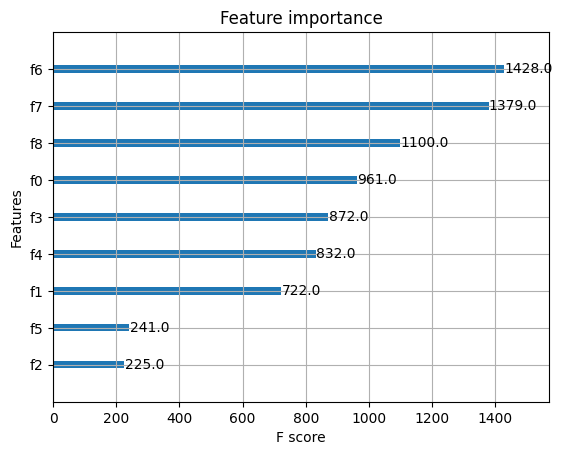

In [25]:
import matplotlib.pyplot as plt

xgb.plot_importance(final_model, max_num_features=10)
plt.show()